<a href="https://colab.research.google.com/github/m-garciar/machine-learning/blob/main/Taller_3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Taller 3 clasificación de imágenes
Maria Fernanda Garcia

In [ ]:
!pip install keras-tuner

     |████████████████████████████████| 133 kB 988 kB/s 


#0. Importacion de librerias

In [ ]:
import pandas as pd
import numpy as np
import random
import urllib.request

import matplotlib.pyplot as plt
import matplotlib.image as image
import matplotlib.cbook as cbook
%matplotlib inline

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow import keras
from pathlib import Path
import glob
import os
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from ast import literal_eval

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential

from keras.layers import Dropout, Flatten, Dense, Input, Rescaling, Lambda
from keras import backend as K
from keras import applications
from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.tensorflow import balanced_batch_generator
from tqdm import tqdm

import keras_tuner as kt

from PIL import Image
import requests
import scipy.misc

from sklearn.metrics import classification_report, confusion_matrix

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.8.0


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#1. Entendimiento del negocio

El objetivo es poder clasificar los poster de las películar por género. Debido a que una misma película puede pertenecer a varios géneros, se realizará una clasificación multietiqueta. 

#2. Entendimiento de los datos

Se realiza la carga de los posters clasificados por los géneros a los cuales pertenecen. Si un poster pertenece a más de un género, este se carga para cada una de las categorías a las que pertenece.  Las URL repetidas  y vacias fueron eliminadas. Es importante resaltar que la categoría de drama esta sobrerepresentadas por lo cual se submuestreo para mejorar el rendimiento. Las categorías adultos, biografía, programa de juego, talk show y reality-show estan muy poco representadas, razón por la cual dificilmente se podrá entrenar un algoritmo para detectarlas y se decide excluirlas.

In [ ]:
!unzip Movies4.zip

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: Thriller/MV5BMTcwMDg0MzI1MV5BMl5BanBnXkFtZTcwNjczMDIyMQ@@._V1_UY268_CR3,0,182,268_AL_.jpg  
  inflating: Thriller/MV5BMTcwMDU1OTEwOF5BMl5BanBnXkFtZTcwMTg5NjEyMQ@@._V1_UY268_CR3,0,182,268_AL_.jpg  
 extracting: Thriller/MV5BMTcwMDY3NjIyMV5BMl5BanBnXkFtZTcwNzkyNTk2Ng@@._V1_UY268_CR4,0,182,268_AL_.jpg  
 extracting: Thriller/MV5BMTcwMjEyMTM4MF5BMl5BanBnXkFtZTgwMjQ2Mjc2MTE@._V1_UX182_CR0,0,182,268_AL_.jpg  
  inflating: Thriller/MV5BMTcwMjk0ODQ5N15BMl5BanBnXkFtZTcwMTkxODkxMQ@@._V1_UX182_CR0,0,182,268_AL_.jpg  
 extracting: Thriller/MV5BMTcwMjY5MzU5Ml5BMl5BanBnXkFtZTcwNjc4MzU5Ng@@._V1_UY268_CR9,0,182,268_AL_.jpg  
  inflating: Thriller/MV5BMTcwMTE5MjY3MF5BMl5BanBnXkFtZTcwMTUzMzA1MQ@@._V1_UX182_CR0,0,182,268_AL_.jpg  
 extracting: Thriller/MV5BMTcwMTM1NDU1Ml5BMl5BanBnXkFtZTgwNDk5MTgzNjE@._V1_UX182_CR0,0,182,268_AL_.jpg  
  inflating: Thriller/MV5BMTcwMTUxNjQxN15BMl5BanBnXkFtZTcwNTYyODcyMQ@@._V1_UX182_CR0,0,182,26

In [ ]:
path = '/content/Movies'
data = pd.read_csv("/MovieGenre.csv", encoding="UTF-8")
data.head()

,imdbId,Imdb_Link,Title,IMDB_Score,Genre,Poster
0,3,http://www.imdb.com/title/tt3,Pauvre Pierrot (1892),6.6,Animation|Comedy|Short,https://images-na.ssl-images-amazon.com/images...
1,5,http://www.imdb.com/title/tt5,Blacksmith Scene (1893),6.2,Short,https://images-na.ssl-images-amazon.com/images...
2,8,http://www.imdb.com/title/tt8,Edison Kinetoscopic Record of a Sneeze (1894),5.6,Documentary|Short,https://images-na.ssl-images-amazon.com/images...
3,12,http://www.imdb.com/title/tt12,The Arrival of a Train (1896),7.4,Documentary|Short,https://images-na.ssl-images-amazon.com/images...
4,14,http://www.imdb.com/title/tt14,Tables Turned on the Gardener (1895),7.2,Comedy|Short,https://images-na.ssl-images-amazon.com/images...


#3. Preparación de los datos

Se define el tamaño del batch y se redimensionan las imágenes

In [ ]:
batch_size = 25
img_height = 256
img_width = 256

Se realiza la división aleatoria de los datos dejando el 80% para la fase de entrenamiento y el 20% para la fase de evaluación. Se emplea una semilla para garantizar la reproducibilidad de la selección.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/Movies',
  label_mode='categorical',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 51505 files belonging to 22 classes.
Using 41204 files for training.


Se crea muestra para evaluación

In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/Movies',
  label_mode='categorical',
  validation_split=0.2,
  subset="validation",
  seed=5,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 51505 files belonging to 22 classes.
Using 10301 files for validation.


Clases cargadas

In [ ]:
class_names = train_ds.class_names
print(class_names)

['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western']


Muestra de imágenes redimensionadas

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


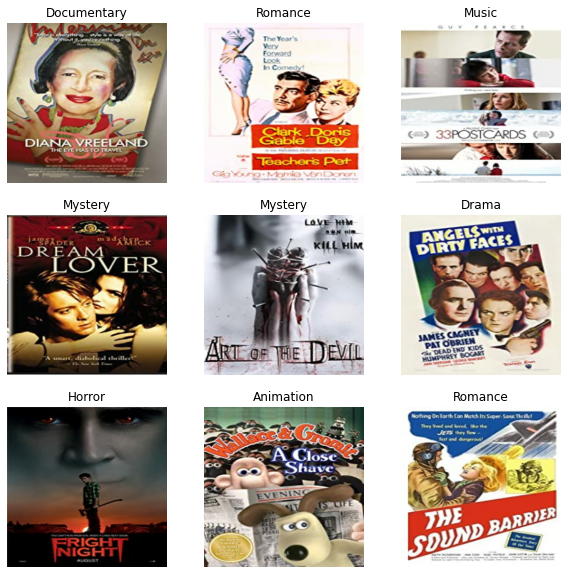

In [ ]:
plt.figure(figsize=(10, 10))
for Movies, labels in train_ds.take(1):
    for i in range(9):
        print(Movies[i].numpy().shape)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(Movies[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().argmax()])
        plt.axis("off")

#4.Modelamiento

In [ ]:
model = Sequential(name="red")

Capa para preparar los datos

In [ ]:
model.add(Input(shape=(img_height, img_width,3),batch_size=None,name='Input_Layer'))
model.add(Rescaling(1./255,name='Rescaling_Layer'))
model.add(Flatten(name='Flatten_Layer'))
model.summary()

Model: "red"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Rescaling_Layer (Rescaling)  (None, 256, 256, 3)      0         
                                                                 
 Flatten_Layer (Flatten)     (None, 196608)            0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


Capas para entrenamiento

In [ ]:
model.add(Dense(500,activation='relu',name='Dense_Layer_1'))
model.add(Dense(100,activation='relu',name='Dense_Layer_2'))
model.add(Dense(500,activation='relu',name='Dense_Layer_3'))
model.add(Dense(50,activation='relu',name='Dense_Layer_4'))
model.add(Dense(20,activation='relu',name='Dense_Layer_5'))
model.add(Dense(10,activation='relu',name='Dense_Layer_6'))
model.summary()

Model: "red"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Rescaling_Layer (Rescaling)  (None, 256, 256, 3)      0         
                                                                 
 Flatten_Layer (Flatten)     (None, 196608)            0         
                                                                 
 Dense_Layer_1 (Dense)       (None, 500)               98304500  
                                                                 
 Dense_Layer_2 (Dense)       (None, 100)               50100     
                                                                 
 Dense_Layer_3 (Dense)       (None, 500)               50500     
                                                                 
 Dense_Layer_4 (Dense)       (None, 50)                25050     
                                                                 
 Dense_Layer_5 (Dense)       (None, 20)                1020    

Capa de salida
Se emplea función de activación sigmoide para cumplir objetivo de clasificación multietiqueta

In [ ]:
model.add(Dense(len(class_names),activation='sigmoid',name='Ans_Layer'))
model.summary()

Model: "red"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Rescaling_Layer (Rescaling)  (None, 256, 256, 3)      0         
                                                                 
 Flatten_Layer (Flatten)     (None, 196608)            0         
                                                                 
 Dense_Layer_1 (Dense)       (None, 500)               98304500  
                                                                 
 Dense_Layer_2 (Dense)       (None, 100)               50100     
                                                                 
 Dense_Layer_3 (Dense)       (None, 500)               50500     
                                                                 
 Dense_Layer_4 (Dense)       (None, 50)                25050     
                                                                 
 Dense_Layer_5 (Dense)       (None, 20)                1020    

Se compila el modelo y se define la función de pérdida, el optimizador y las métricas que se van a emplear.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='sgd',metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

Model: "red"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Rescaling_Layer (Rescaling)  (None, 256, 256, 3)      0         
                                                                 
 Flatten_Layer (Flatten)     (None, 196608)            0         
                                                                 
 Dense_Layer_1 (Dense)       (None, 500)               98304500  
                                                                 
 Dense_Layer_2 (Dense)       (None, 100)               50100     
                                                                 
 Dense_Layer_3 (Dense)       (None, 500)               50500     
                                                                 
 Dense_Layer_4 (Dense)       (None, 50)                25050     
                                                                 
 Dense_Layer_5 (Dense)       (None, 20)                1020    

##Esquema del modelo

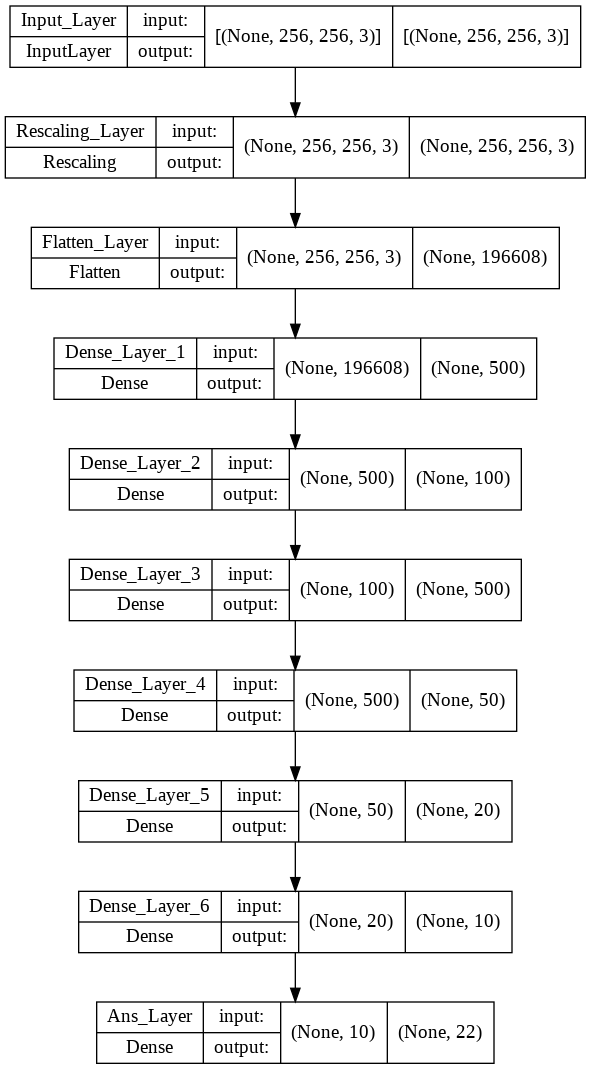

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

# 5. Entrenamiento

In [ ]:
history = model.fit(train_ds,
        validation_data=val_ds,
        epochs=50
    )

Epoch 1/50
1649/1649 [==============================] - 53s 32ms/step - loss: 0.1687 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 0.1690 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/50
1649/1649 [==============================] - 47s 28ms/step - loss: 0.1687 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 0.1690 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/50
1649/1649 [==============================] - 44s 26ms/step - loss: 0.1687 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 0.1690 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 4/50
1649/1649 [==============================] - 47s 28ms/step - loss: 0.1687 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 0.1690 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 5/50
1649/1649 [==============================] - 45s 27ms/step - loss: 0.1687 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 0.1690 - val_p

KeyboardInterrupt: ignored

In [ ]:
y_true = list()
y_pred = list()

for Movies, labels in train_ds:
    pred = model.predict(Movies)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] == pred[i].max()).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true, y_pred

(array([[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]))

In [ ]:
print(classification_report(y_true,y_pred,target_names=list(class_names)))

              precision    recall  f1-score   support

      Action       0.25      0.35      0.29       879
   Adventure       0.20      0.27      0.23      2616
   Animation       0.19      0.28      0.22       650
      Comedy       0.30      0.23      0.26      4846
       Crime       0.15      0.16      0.15       387
 Documentary       0.19      0.52      0.28      2713
       Drama       0.29      0.34      0.31      5649
      Family       0.19      0.19      0.19      1442
     Fantasy       0.13      0.26      0.18      1469
   Film-Noir       0.12      0.13      0.12       262
     History       0.18      0.19      0.18      1019
      Horror       0.24      0.55      0.34      2923
       Music       0.17      0.24      0.20       906
     Musical       0.33      0.06      0.10       584
     Mystery       0.17      0.39      0.24      1734
     Romance       0.30      0.22      0.25      5658
      Sci-Fi       0.15      0.41      0.22      1472
       Short       0.09    

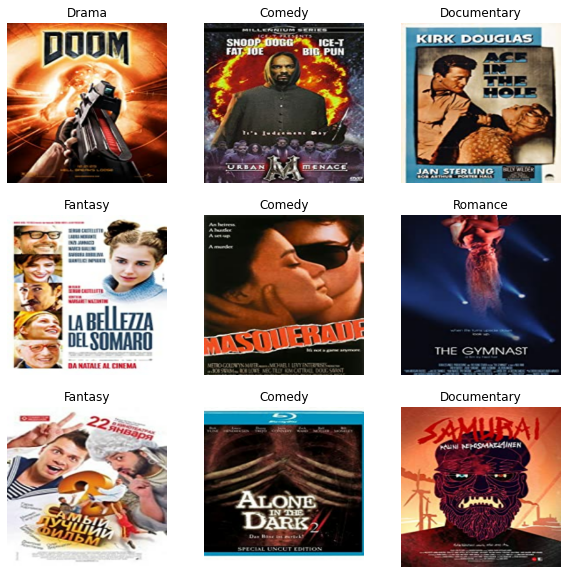

In [ ]:
plt.figure(figsize=(10, 10))

df = train_ds.take(1)
pred = model.predict(df)
for Movies, labels in df:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(Movies[i].numpy().astype("uint8"))
        plt.title(class_names[pred[i].argmax()])
        plt.axis("off")

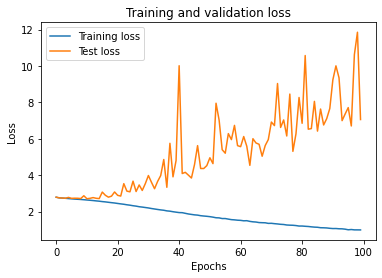

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['recall_1'], label='Training recall')
plt.plot(history.history['val_recall_1'], label='Test recall')
plt.plot(history.history['precision_1'], label='Training precision')
plt.plot(history.history['val_precision_1'], label='Test precision')
plt.title('Training and validation metrics')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#6.Validación

Se realiza el mismo proceso pero con los datos de evaluación

In [ ]:
y_true = list()
y_pred = list()

for Movies, labels in val_ds:
    pred = model.predict(Movies)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] == pred[i].max()).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true, y_pred

(array([[0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0]]))

In [ ]:
print(classification_report(y_true,y_pred,target_names=list(class_names)))

              precision    recall  f1-score   support

      Action       0.05      0.06      0.06       234
   Adventure       0.06      0.09      0.07       617
   Animation       0.04      0.06      0.05       161
      Comedy       0.11      0.07      0.09      1223
       Crime       0.01      0.01      0.01        97
 Documentary       0.08      0.23      0.12       675
       Drama       0.13      0.16      0.14      1415
      Family       0.07      0.06      0.06       362
     Fantasy       0.03      0.07      0.05       353
   Film-Noir       0.04      0.05      0.04        61
     History       0.03      0.03      0.03       281
      Horror       0.10      0.25      0.15       714
       Music       0.04      0.05      0.05       247
     Musical       0.00      0.00      0.00       144
     Mystery       0.07      0.16      0.10       408
     Romance       0.11      0.08      0.09      1411
      Sci-Fi       0.04      0.10      0.05       352
       Short       0.02    

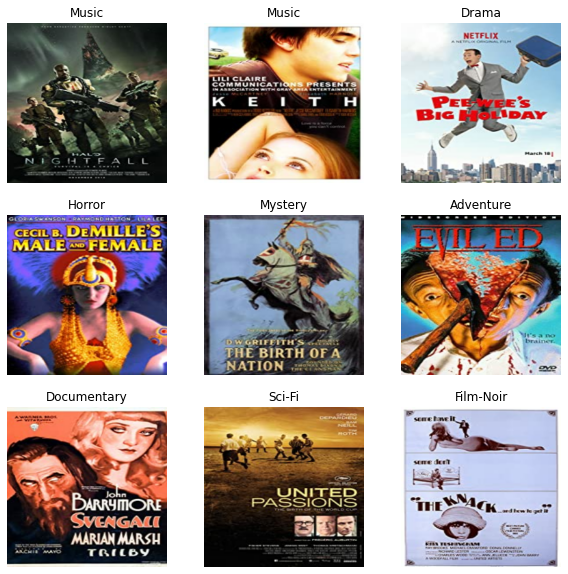

In [ ]:
plt.figure(figsize=(10, 10))

df = val_ds.take(1)
pred = model.predict(df)
for images, labels in df:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[pred[i].argmax()])
        plt.axis("off")

In [ ]:
def entrenarRed(hp):
    clf = Sequential(name='Otra_red')
    output = len(class_names)
    n_layers = hp.Choice('n_layers', [5, 6, 7])
    neuronas = hp.Choice('units', ['[1000, 100, 512, 256, 20, 456, 40]','[512,256,128,256,64,32,16]','[1000,500,200,100,50,20,10]'])
    neuronas = eval(neuronas)
    dropout = hp.Choice('dropout', [0.1,0.2,0.3])

    clf.add(Input(shape=(img_height, img_width,3),batch_size=None,name='Input_Layer'))
    clf.add(Rescaling(1./255,name='Rescaling_Layer'))
    clf.add(Flatten(name='Flatten_Layer'))

    for i in range(n_layers):
        clf.add(Dense(neuronas[i], activation=hp.Choice('activacion_oculta', ['relu','sigmoid']), name = 'Capa_Oculta_{0}'.format(i)))
        clf.add(Dropout(dropout,name='Dropout_{0}_{1}'.format(dropout,i)))

    clf.add(Dense(output, activation='sigmoid', name= 'Capa_Salida'))

    clf.compile(loss='categorical_crossentropy', optimizer='sgd',metrics=["accuracy",tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    
    return clf

tuner = kt.RandomSearch(
    entrenarRed,
    objective="val_accuracy",
    seed=123,
    max_trials=10)

In [ ]:
with tf.device('/device:GPU:0'): 
    tuner.search(train_ds,
             validation_data=val_ds,
             epochs=30)
    
best_model = tuner.get_best_models()[0]

INFO:tensorflow:Oracle triggered exit


Debido a que no se logro convergencia para la búsqueda del mejor modelo, se elige modelo inicial el cual tiene un desempeño muy pobre para la clasificación de poster.